In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from copy import deepcopy
from evo.core.metrics import PoseRelation, Unit
from evo.core import sync
from evo.core.sync import TrajectoryPair
from evo.tools import file_interface, plot, pandas_bridge
from evo.tools.plot import PlotMode
from evo.tools.settings import SETTINGS
from os import path
from rosbags.rosbag2.reader import Reader as BagReader
from tools.tum_plots import *
from tools.tum_tools import *


# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = True

%load_ext autoreload
%autoreload 2

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib widget



## Plotting

### Data Read

In [2]:
# Root of all data
data_root = "/home/julian/projects/thesis/datasets/df_analysis/"

result_figure_dir_root = "/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA/02_Figures/08_ch-6-results/"

EKF_TOPIC = "/ekf_pose_with_covariance"
GT_GPS_TOPIC = "/ekf/gt/gps"
KISS_TOPIC = "/kiss/odometry"

N_RUNS = 3


route_01 = "mdv3_1"
route_02 = "mdv3_2"
routes = [route_01, route_02]

data_set_01 = "01_no_kiss" # Only GPS & IMU are fused
data_set_02 = "02_with_kiss" # GPS & IMU & KISS are fused
data_set_03 = "03_with_kiss-cov-v2" #  GPS & IMU & KISS are fused + modified Covariance for KISS
data_set_04 = "04_with_outage" # GPS Outage
test_scenarios = [data_set_01, data_set_02, data_set_03, data_set_04]

# Nested datasets
datasets = [(r, test_scenarios) for r in routes]

# Main datastructure with all inputs combined
DATA = defaultdict(dict)

def read_trajectories_from_run(data_path, run_index):
    bag_path = os.path.join(data_path, f"run_{run_index:02d}")
    bag_reader = BagReader(bag_path)
    bag_reader.open()
    gps_file = path.join("data/reference/mdv3_1_reference.tum")

    traj_ref = file_interface.read_tum_trajectory_file(gps_file)
    traj_gt_gps = file_interface.read_bag_trajectory(bag_reader, GT_GPS_TOPIC)
    traj_ekf = file_interface.read_bag_trajectory(bag_reader, EKF_TOPIC)
    
    try:
        traj_kiss = file_interface.read_bag_trajectory(bag_reader, KISS_TOPIC)
    except:
        traj_kiss = None
    
    bag_reader.close()    
    return traj_ref, traj_gt_gps, traj_ekf, traj_kiss


def read_data(path, run):
    try:
        t = read_trajectories_from_run(path, run)
        return {"REF": t[0], "GT_GPS": t[1], "EKF": t[2], "KISS": t[3]}
    except Exception as e:
        print(e)
        return None

DATA = {
    route: {
        ds: {i: read_data(os.path.join(data_root, route, ds), i) 
             for i in range(1, N_RUNS + 1)}
        for ds in scenarios
    } 
    for route, scenarios in datasets
}

Could not read metadata at /home/julian/projects/thesis/datasets/df_analysis/mdv3_2/03_with_kiss-cov-v2/run_01/metadata.yaml: [Errno 2] No such file or directory: '/home/julian/projects/thesis/datasets/df_analysis/mdv3_2/03_with_kiss-cov-v2/run_01/metadata.yaml'.
Could not read metadata at /home/julian/projects/thesis/datasets/df_analysis/mdv3_2/03_with_kiss-cov-v2/run_02/metadata.yaml: [Errno 2] No such file or directory: '/home/julian/projects/thesis/datasets/df_analysis/mdv3_2/03_with_kiss-cov-v2/run_02/metadata.yaml'.
Could not read metadata at /home/julian/projects/thesis/datasets/df_analysis/mdv3_2/03_with_kiss-cov-v2/run_03/metadata.yaml: [Errno 2] No such file or directory: '/home/julian/projects/thesis/datasets/df_analysis/mdv3_2/03_with_kiss-cov-v2/run_03/metadata.yaml'.
Could not read metadata at /home/julian/projects/thesis/datasets/df_analysis/mdv3_2/04_with_outage/run_01/metadata.yaml: [Errno 2] No such file or directory: '/home/julian/projects/thesis/datasets/df_analysis

In [11]:
## SETUP

# Select which route to focus on
route = route_02

# Select which set to focus on
# 01: EKF only with GPS + IMU
# 02: EKF with GPS + IMU + KISS-ICP
# 03: EKF with GPS + IMU + KISS-ICP increased Cov for KISS-ICP: (run_01: *10 // run_02: *50 // run_03: *100)
# 04: EKF with GPS + IMU + KISS-ICP + Short GPS Outage (Mdv3_1: 2000-2500)  increased Cov for KISS-ICP: (run_01: *10 // run_02: *50 // run_03: *100)
data_set = data_set_02

# Load data in local structure -> Deepcopy to avoid re-reading
data = deepcopy(DATA[route][data_set])

# Set save paths for images
if data_set.startswith("01"): result_figure_dir = os.path.join(result_figure_dir_root, "02-ekf-analysis")
elif data_set.startswith("02"): result_figure_dir = os.path.join(result_figure_dir_root, "03_kiss_ekf-analysis")
elif data_set.startswith("03"): result_figure_dir = os.path.join(result_figure_dir_root, "04_kiss_ekf-analysis-cov-v2")


# Globally equal max time difference for comparison
g_max_diff = 0.001
g_max_diff_ape = 0.001
g_max_diff_rpe = 0.01

run = 1

est_trajectory_type = "EKF"

In [13]:
# rosbag = "/home/julian/projects/thesis/datasets/df_analysis/mdv3_2/02_with_kiss/run_01/"
# out = "/home/julian/projects/thesis/kiss-icp/ekf_out.txt"
# pose_with_covariance_to_txt(rosbag, EKF_TOPIC, out)

file_interface.write_tum_trajectory_file("kiss_poses.tum", data[1]["KISS"])

In [ ]:
# Compare data across all runs of one test set
trajectory_type = "EKF"
plot_mode = "xyz"
trajectories, names = [],[]

for i in range(1, N_RUNS+1):
    names.append(f"run_{i:02d}")
    trajectories.append(data[i][trajectory_type])

names.append("Reference")
trajectories.append(data[1]["GT_GPS"])
compare_plot_multiple(trajectories, names, plot_mode=plot_mode, wf=2, hf=0.5)

# fig_name = f"compare_{route_switch}_{trajectory_type}_{version_switch}_{test_set_switch}_{plot_mode}.pdf"
# plt.savefig(path.join(result_figure_dir, fig_name), format="pdf", bbox_inches="tight")

## Trajectory Plot for all runs

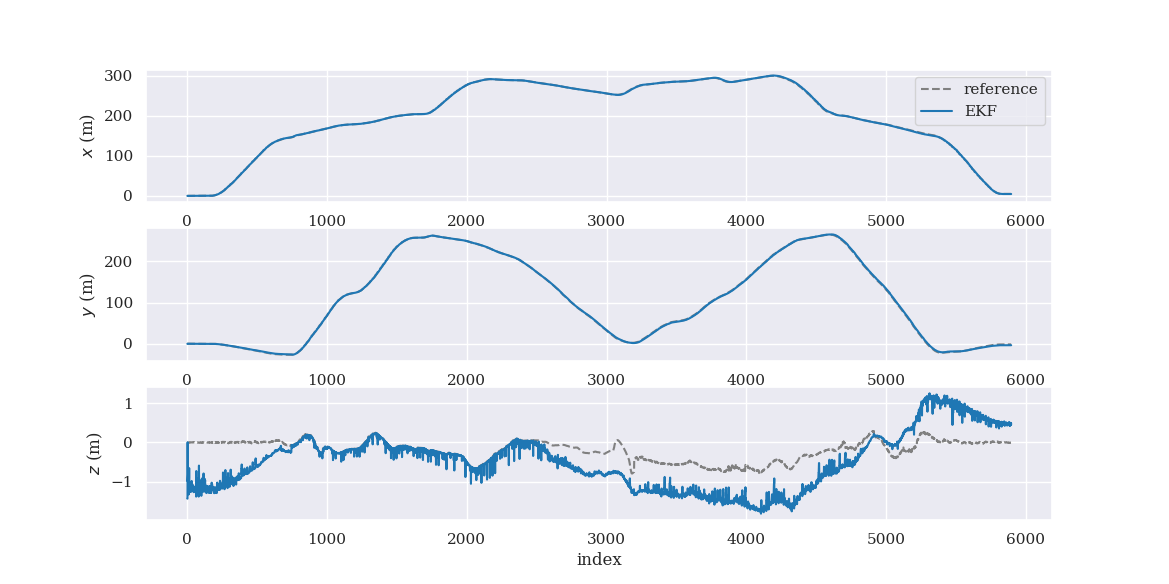

In [4]:
# Compare for Errors
plt.close('all')


traj_ref = deepcopy(data[run]['GT_GPS'])
traj_est = deepcopy(data[run][est_trajectory_type])


traj_est_kiss = deepcopy(DATA[route][data_set_03][run]["KISS"])
traj_est2 = deepcopy(DATA[route][data_set_03][run][est_trajectory_type])
traj_out = deepcopy(DATA[route][data_set_04][run][est_trajectory_type])

plot_compare((traj_ref, traj_est), plot_mode='xyz', est_name=est_trajectory_type, print_stats=True, 
             pose_relation=PoseRelation.full_transformation, max_diff=g_max_diff_rpe)

# plt.savefig(path.join(result_figure_dir, f"{route}_ape_trajectory.pdf"), format="pdf", bbox_inches="tight")
# plt.savefig(path.join(result_figure_dir, f"{route}_ekf-xyz_plot.pdf"), format="pdf", bbox_inches="tight")


In [ ]:
traj_ref = deepcopy(data[run]['GT_GPS'])
traj_est = deepcopy(data[run][est_trajectory_type])
traj_ref, traj_est = tum_tools.sync_trajectories(traj_ref, traj_est, g_max_diff)

plot_compare((traj_ref, traj_ref), plot_mode="xyz")

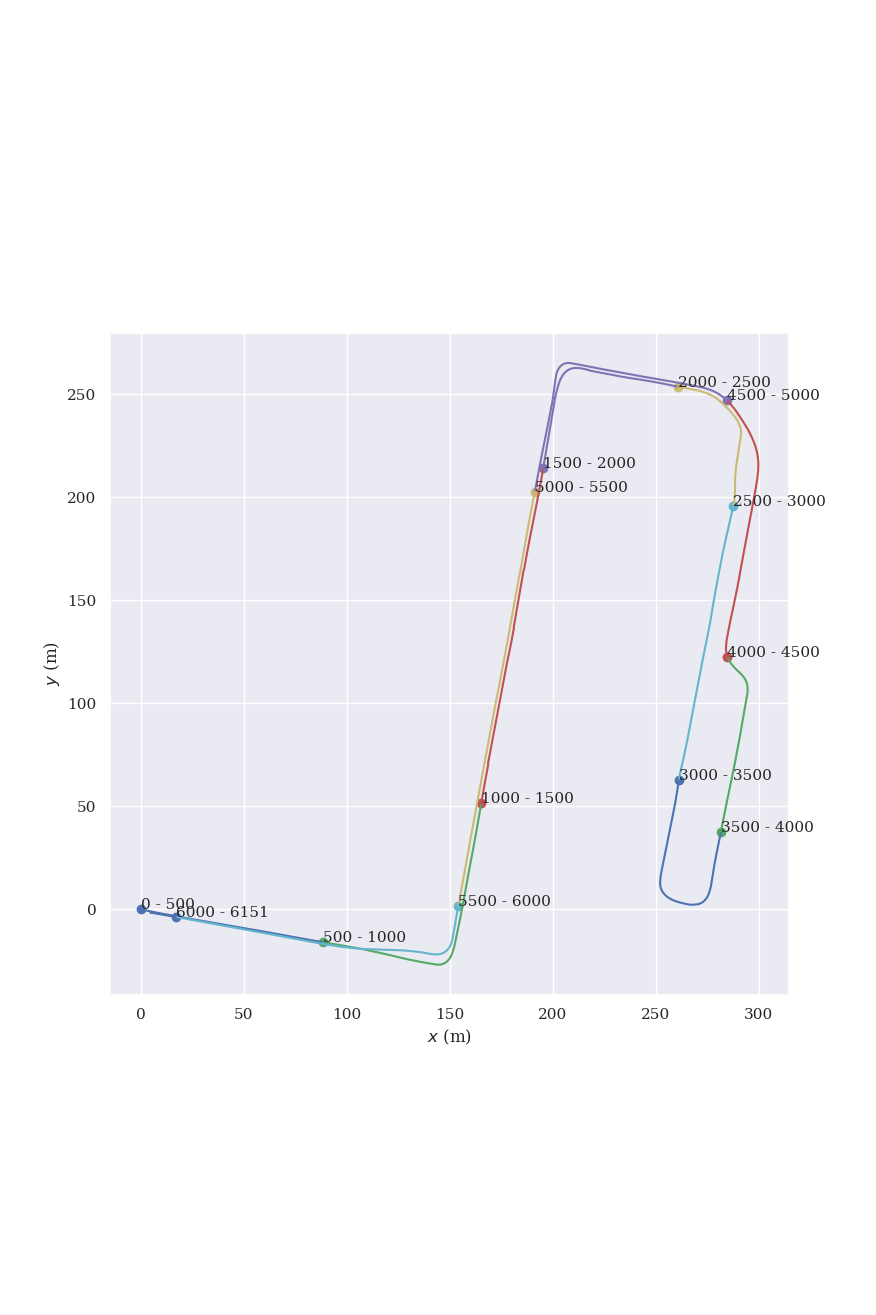

In [99]:
# Plot the segemnts
segment_size = 500
run=1

traj_ref = deepcopy(data[run]['GT_GPS'])
# traj_est = deepcopy(data[run][est_trajectory_type])
# aligned, _ = tum_tools.sync_trajectories(traj_ref, traj_ref, g_max_diff)

plot_trajectory_segments(traj_ref, n=segment_size, wf=1.5, hf=1.5)

## APE

In [ ]:
plt.close('all')

pose_relations = [metrics.PoseRelation.translation_part, metrics.PoseRelation.rotation_angle_deg, metrics.PoseRelation.full_transformation]

traj_ref = deepcopy(data[run]["GT_GPS"])
traj_est = deepcopy(data[run][est_trajectory_type])
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=g_max_diff_ape)


for pose_relation in pose_relations:
    ape_metric = metrics.APE(pose_relation=pose_relation)
    ape_metric.process_data((traj_ref, traj_est))
    # plot_statistical_error_metric(ape_metric, show_plot=False, save_dir=result_figure_dir, name_prefix=route)
    plot_statistical_error_metric(ape_metric, show_plot=False, save_dir="", name_prefix=route)


## RPE

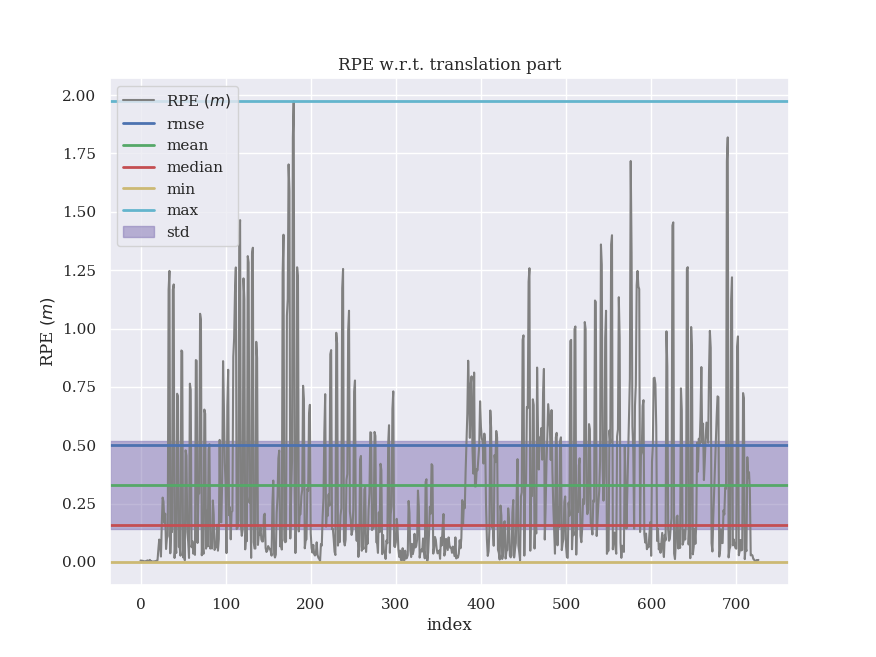

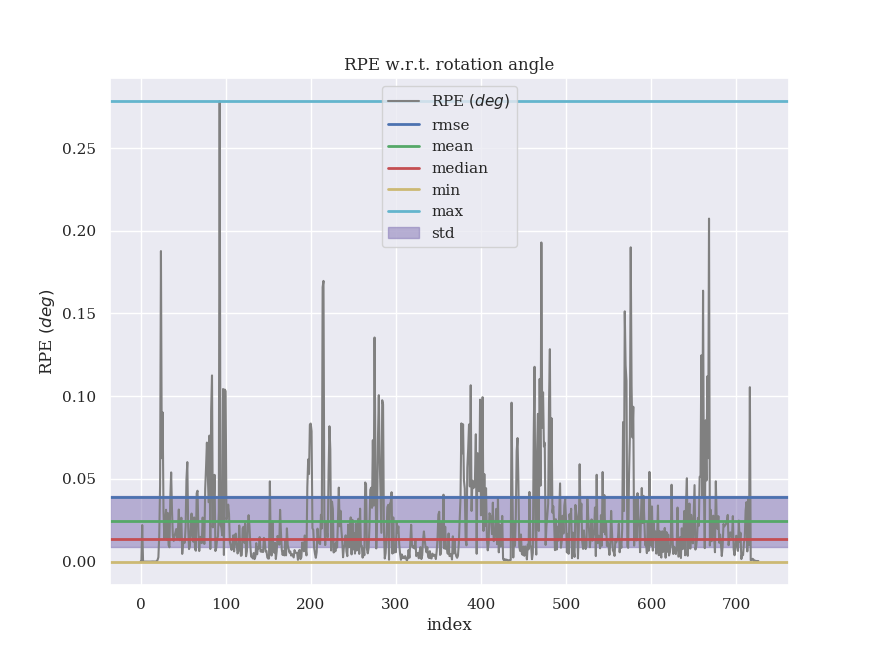

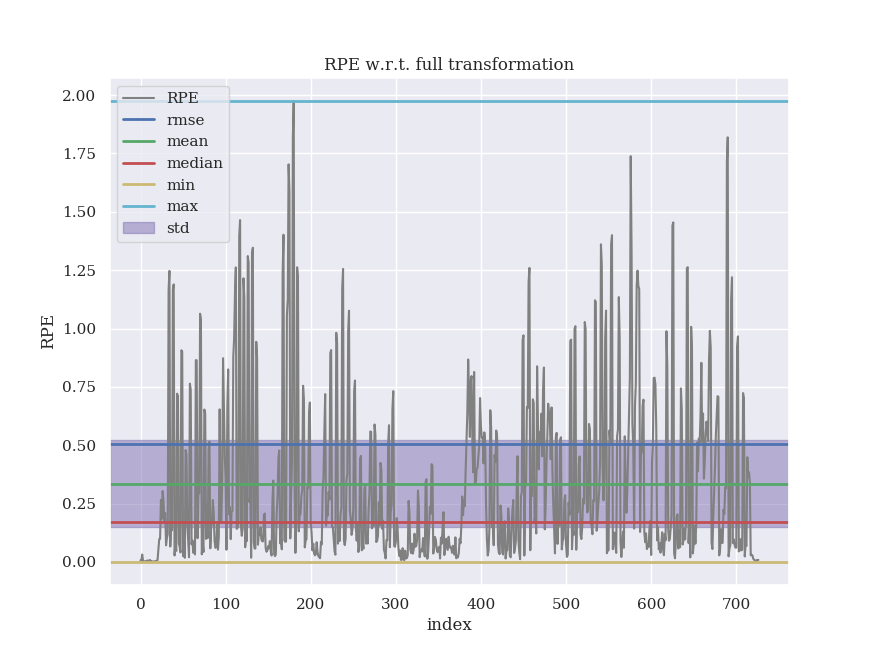

In [78]:
plt.close('all')

delta = 8
all_pairs = False 
delta_unit = Unit.frames

pose_relations = [metrics.PoseRelation.translation_part, metrics.PoseRelation.rotation_angle_deg, metrics.PoseRelation.full_transformation]

traj_ref = deepcopy(data[run]["GT_GPS"])
traj_est = deepcopy(data[run][est_trajectory_type])
# traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=0.01)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=g_max_diff_rpe)

for pose_relation in pose_relations:
    rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
    rpe_metric.process_data((traj_ref, traj_est))
    plot_statistical_error_metric(rpe_metric, show_plot=False, save_dir=result_figure_dir, name_prefix=route)
    # plot_statistical_error_metric(rpe_metric, show_plot=False, save_dir="", name_prefix=route)


# traj_ref_plot = deepcopy(traj_ref)
# traj_est_plot = deepcopy(traj_est)
# traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
# traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]


## Advanced Plots for direct comparison

In [ ]:


colormap = SETTINGS.plot_multi_cmap

df = pandas_bridge.result_to_df(result, "EKF")
keys = df.columns.values.tolist()
error_df = pd.DataFrame(df.loc["np_arrays", "error_array"].tolist(),
                                index=keys).T

metric_label = df.loc["info", "label"].iloc[0]
print(f"Metic Label: {metric_label}")

# fig_raw = plt.figure(figsize=get_figsize())
# # handle NaNs from concat() above
# error_df.interpolate(method="index", limit_area="inside").plot(
#     ax=fig_raw.gca(), title="", alpha=SETTINGS.plot_trajectory_alpha)
# # plt.xlabel(index_label)
# # plt.ylabel(metric_label)
# plt.legend(frameon=True)
# plt.show()

# fig_stats = plt.figure(figsize=get_figsize())
# include = df.loc["stats"].index.isin(SETTINGS.plot_statistics)
# if any(include):
#     df.loc["stats"][include].plot(kind="barh", ax=fig_stats.gca(), stacked=False)
#     # plt.xlabel(metric_label)
#     plt.legend(frameon=True)
# plt.show()
plt.close('all')
# print(df)
raw_tidy = pd.melt(error_df, value_vars=list(error_df.columns.values), var_name="estimate", value_name=metric_label)
# print(raw_tidy)
# col_wrap = 2 if len(args.result_files) <= 2 else math.ceil(len(args.result_files) / 2.0)
# dist_grid = sns.FacetGrid(raw_tidy, col="estimate", col_wrap=2)
# dist_grid.map(sns.distplot, metric_label)  # fits=stats.gamma
# sns.histplot(data=raw_tidy, x=metric_label, kde=True)
data = raw_tidy[metric_label].to_numpy()
data = np.array(data)
data= data[..., np.newaxis]
print(data.shape)
# sns.histplot(data=(raw_tidy[metric_label]).to_numpy(), stat='density', kde=True)
sns.histplot(data=data, stat='density', kde=True)
# sns.displot(data=raw_tidy[metric_label], )


# fig_box = plt.figure(figsize=get_figsize())
# ax = sns.boxplot(x=raw_tidy["estimate"], y=raw_tidy[metric_label],
                    #  ax=fig_box.gca())
    # ax.set_xticklabels(labels=[item.get_text() for item in ax.get_xticklabels()], rotation=30)
# plt.show()
    
# violin plot
# fig_violin = plt.figure(figsize=get_figsize())
# ax = sns.violinplot(x=raw_tidy["estimate"], y=raw_tidy[metric_label],
#                     ax=fig_violin.gca())
# ax.set_xticklabels(labels=[item.get_text() for item in ax.get_xticklabels()], rotation=30)
# plt.show()
